In [2]:
#base
import os, sys
import datetime
from scipy import stats
import numpy as np
import pandas as pd
import re
import json
from pandas.io.json import json_normalize
import pickle
from urllib.parse import urlparse
from urllib.request import urlretrieve, unquote
#text block
import unicodedata
#requests block
import bs4
import requests
#vectorizers
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
#classifiers
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#validation
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#pipeline block
from sklearn.pipeline import Pipeline
#visuals
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
%matplotlib inline

Посмотрим, что вообще нам досталось

In [3]:
%%time
file_path = '/data/share/project01/gender_age_dataset.txt'
raw_data = pd.read_csv(file_path, sep='\t')

CPU times: user 7.65 s, sys: 4.9 s, total: 12.5 s
Wall time: 12.6 s


In [4]:
raw_data.head(1)

gender    age                                   uid  \
0      F  18-24  d50192e5-c44e-4ae8-ae7a-7cfe67c8b777   

                                           user_json  
0  {"visits": [{"url": "http://zebra-zoya.ru/2000...

In [5]:
pd.isnull(raw_data).sum()

gender       0
age          0
uid          0
user_json    0
dtype: int64

Хотя бы нет пустых значений, и слава богу. Посмотрим, как распределены классы в выборке.

In [5]:
raw_data.groupby(by=['gender', 'age']).count()

uid  user_json
gender age                   
-      -      5000       5000
F      18-24  2886       2886
       25-34  6791       6791
       35-44  4271       4271
       45-54  2597       2597
       >=55    895        895
M      18-24  2012       2012
       25-34  8666       8666
       35-44  5089       5089
       45-54  2147       2147
       >=55    784        784

In [6]:
raw_data[raw_data.age != '-'].groupby(by=['gender', 'age']).count().apply(lambda x: 100*x/sum(x)).uid

gender  age  
F       18-24     7.986053
        25-34    18.791853
        35-44    11.818584
        45-54     7.186341
        >=55      2.476617
M       18-24     5.567547
        25-34    23.980298
        35-44    14.082130
        45-54     5.941115
        >=55      2.169462
Name: uid, dtype: float64

Мужчины 25-34 составляют 23.98% выборки. Очень жаль, если бы они составляли хотя бы 28%, можно было бы построить роскошную модель "Вы мужчина, вам 25-34 в 100% случаев". Ну, хотя бы эти 0.24 можно взять за бейзлайн.
Посмотрим на данные в разрезе посещений, а не посетителей. Для этого развернем вспомогательный датафрейм vdf с днями недели и часами посещений

In [13]:
def url2domain(url):
    url = re.sub('(http(s)*://)+', 'http://', url)
    parsed_url = urlparse(unquote(url.strip()))
    if parsed_url.scheme not in ['http','https']: return None
    netloc = re.search("(?:www\.)?(.*)", parsed_url.netloc).group(1)
    if netloc is not None: return str(netloc.encode('utf8')).strip()
    return None

data = (raw_data.drop('user_json', axis=1)
                    .join(raw_data['user_json'].apply(lambda x: json.loads(x)))
                    .to_dict('records'))
vdf = json_normalize(data, [['user_json','visits']], ['uid','gender','age'])
vdf = vdf[vdf.age != '-']
vdf['date'] = pd.to_datetime(vdf['timestamp'], unit='ms')
vdf['hour'] = pd.DatetimeIndex(vdf['date']).hour
vdf['weekday'] = pd.DatetimeIndex(vdf['date']).dayofweek
vdf['domain'] = vdf['url'].map(url2domain)

In [8]:
vdf.head(1)

timestamp                                                url  \
0  1419688144068  http://zebra-zoya.ru/200028-chehol-organayzer-...   

                                    uid gender    age                    date  \
0  d50192e5-c44e-4ae8-ae7a-7cfe67c8b777      F  18-24 2014-12-27 13:49:04.068   

   hour  weekday            domain  
0    13        5  b'zebra-zoya.ru'

In [9]:
pd.isnull(vdf).sum()

timestamp    0
url          0
uid          0
gender       0
age          0
date         0
hour         0
weekday      0
domain       0
dtype: int64

In [10]:
total = len(vdf)
total

5312952

In [11]:
vdf.groupby(by=['gender', 'age']).count().uid

gender  age  
F       18-24     213964
        25-34     662515
        35-44     629093
        45-54     338693
        >=55      106715
M       18-24     272569
        25-34    1394530
        35-44    1074861
        45-54     458786
        >=55      161226
Name: uid, dtype: int64

In [12]:
vdf.groupby(by=['gender']).count().apply(lambda x: 100*x/sum(x)).uid

gender
F    36.721205
M    63.278795
Name: uid, dtype: float64

In [13]:
vdf.groupby(by=['gender', 'age']).count().apply(lambda x: 100*x/sum(x)).uid

gender  age  
F       18-24     4.027215
        25-34    12.469810
        35-44    11.840743
        45-54     6.374855
        >=55      2.008582
M       18-24     5.130274
        25-34    26.247743
        35-44    20.230956
        45-54     8.635237
        >=55      3.034584
Name: uid, dtype: float64

Все ок, подвохов с отсутствующими значениями нет. Имеем больше 5 млн. посещений, что пугает, если вдруг придется потом ходить по ссылкам и собирать тексты для корпуса. 
Уже сейчас можно заметить, что мужчины ходят по сайтам с гораздо большим энтузиазмом - почти в два раза больше посещений. Breaking news - люди старше 55 - редкие гости интернета!
Посмотрим, как распределяются посещения по нашим классам.

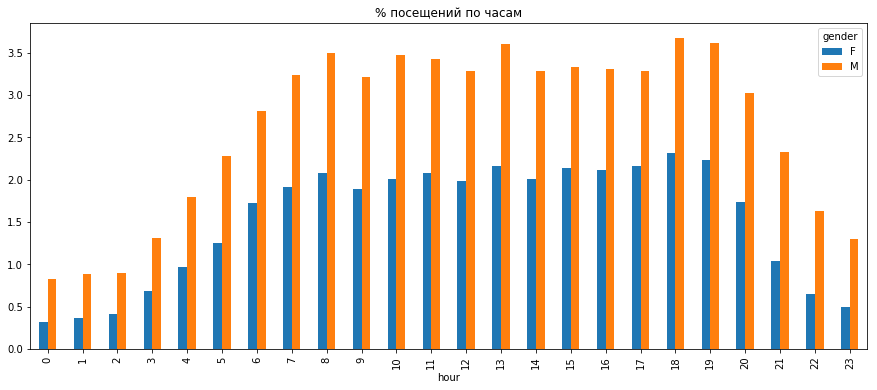

In [14]:
pd.pivot_table(vdf, index = ['hour'], columns=['gender'], aggfunc='count', values = 'uid')\
.apply(lambda x: 100*x/total).plot(figsize=(15,6), kind='bar', title='% посещений по часам')

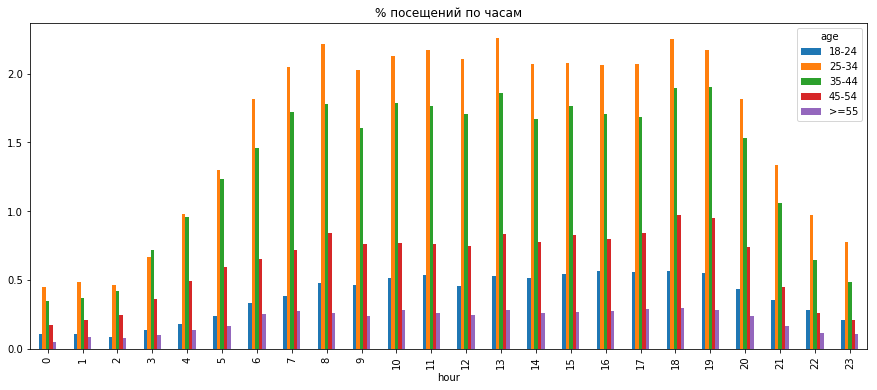

In [15]:
pd.pivot_table(vdf, index = ['hour'], columns=['age'], aggfunc='count', values = 'uid')\
.apply(lambda x: 100*x/total).plot(figsize=(15,6), kind='bar', title='% посещений по часам')

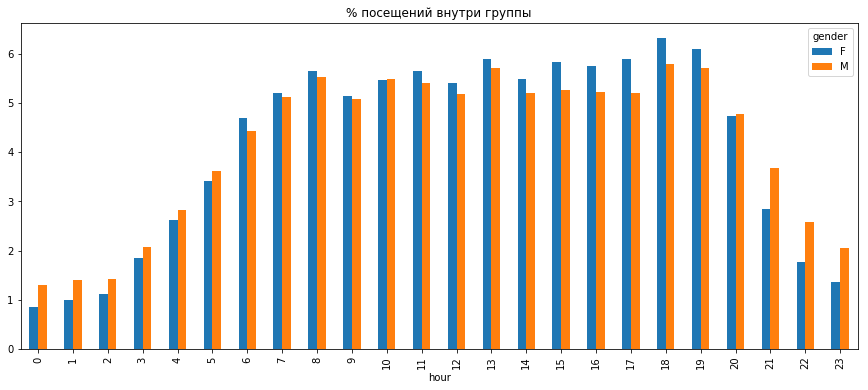

In [16]:
pd.pivot_table(vdf, index = ['hour'], columns=['gender'],aggfunc='count', values = 'uid')\
.apply(lambda x: 100*x/sum(x)).plot(figsize=(15,6), kind='bar', title = '% посещений внутри группы')

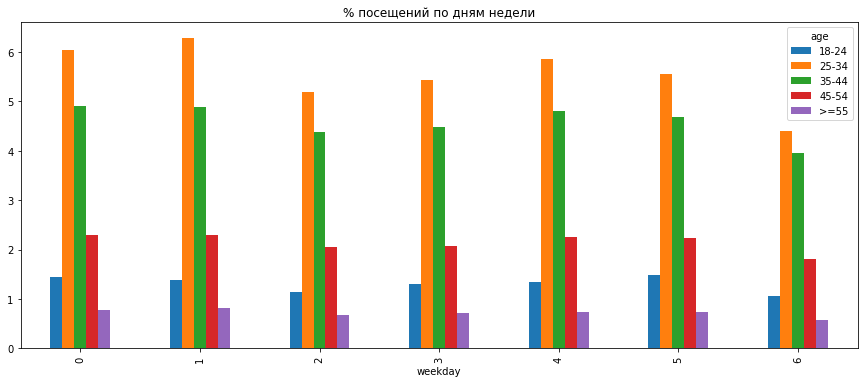

In [17]:
pd.pivot_table(vdf, index = ['weekday'], columns=['age'], aggfunc='count', values = 'uid').\
apply(lambda x: 100*x/total).plot(figsize=(15,6), kind='bar', title='% посещений по дням недели')

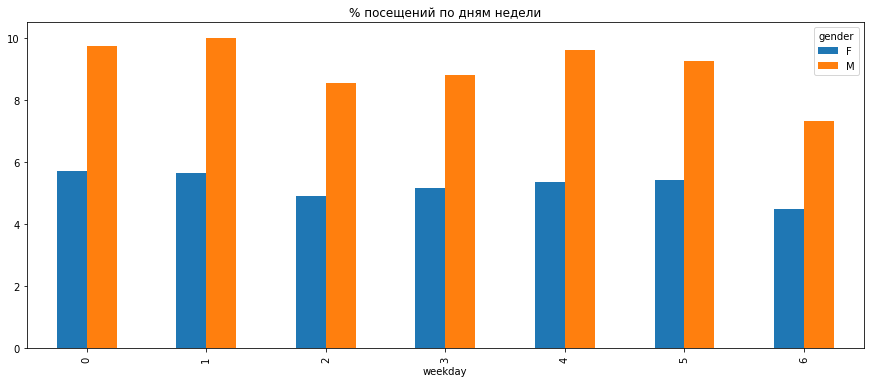

In [18]:
pd.pivot_table(vdf, index = ['weekday'], columns=['gender'], aggfunc='count', values = 'uid').\
apply(lambda x: 100*x/total).plot(figsize=(15,6), kind='bar', title='% посещений по дням недели')

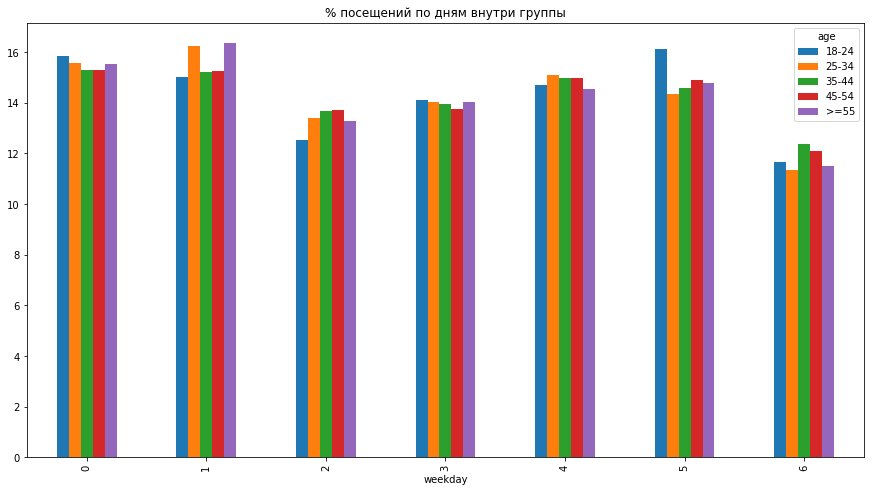

In [19]:
pd.pivot_table(vdf, index = ['weekday'], columns=['age'], aggfunc='count', values = 'uid')\
.apply(lambda x: 100*x/sum(x))\
.plot(figsize=(15,8), kind='bar', title='% посещений по дням внутри группы')

Дисбаланса по дням недели не видно. Жаль, хотелось бы сделать вывод вроде "Ага! Все, блуждающие по интернету в субботу в два часа ночи - мужчины старше 55!". Впрочем, в дальнейшем можно добавить признаки с долей посещений в рабочее, дневное и выходное время. Главное - можно относительно смело перейти к агрегированным признакам - не рассматривать каждое посещение в отдельности, а считать средние, моды и медианы по спискам в разрезе uid. Пока глянем еще на наиболее часто встречающиеся домены, вдруг увидим потенциальные фичи.

In [20]:
pd.pivot_table(vdf, index =['domain'], columns=['gender', 'age'], 
               fill_value=0, aggfunc='count', values = 'uid', margins=True)\
.sort_values(by='All', ascending=False).head(10)

gender                   F                                       M           \
age                  18-24   25-34   35-44   45-54    >=55   18-24    25-34   
domain                                                                        
All                 213964  662515  629093  338693  106715  272569  1394530   
b'avito.ru'          15974   52886   48291   23264    5921   17394   113177   
b'smotri.com'          356    1070    3863     480       8    7404    95733   
b'24open.ru'          3834    5252   11211    3822    3191     755    18144   
b'loveplanet.ru'      2512    6996    9100    4053    1206    2665    26934   
b'youtube.com'        2215    8509    7169    3236    1036    7529    24326   
b'mail.rambler.ru'    3331   10500    8270    5069    1808    1669    15561   
b'vk.com'            10967    7621    3268     962     273   22158    24567   
b'yandex.ru'          3777   13391    8894    4660    1676    3011    16200   
b'ebay.com'           1867    3954    8292    1692     596    2123    10240   

gender                                           All  
age                   35-44   45-54    >=55           
domain                                                
All                 1074861  458786  161226  5312952  
b'avito.ru'          111403   38970    8315   435595  
b'smotri.com'         46330   26052    5946   187242  
b'24open.ru'          18053   15076    3775    83113  
b'loveplanet.ru'      19262    8005    1693    82426  
b'youtube.com'        15508    4903    1108    75539  
b'mail.rambler.ru'    14878    9271    3199    73556  
b'vk.com'              1909     267      67    72059  
b'yandex.ru'          10372    4991    1254    68226  
b'ebay.com'           17462    4516    2192    52934

Нас будут интересовать те домены, в посещении которых особенно усердствует какой-либо класс. Допустим, те, чья доля посещений превышает 0.5. Ну и трешхолд на 2000 добавим

In [21]:
ddf=pd.pivot_table(vdf, index = ['domain'], columns=['gender', 'age'], 
               fill_value=0, aggfunc='count', values = 'uid')
ddf['share'] = ddf.max(axis=1)/ddf.sum(axis=1)

In [22]:
ddf[(ddf.share > 0.5) & (ddf.sum(axis=1) > 2000)].head(10)

gender                F                            M                         \
age               18-24 25-34 35-44 45-54 >=55 18-24 25-34 35-44 45-54 >=55   
domain                                                                        
b'11x11.ru'           0     1     0     3    0    58  3555     0     0    0   
b'123magazin.ru'      0  1984     4     1    2     0     4     3    45    0   
b'5lb.ru'             4    17    13    63    0   622  1304   119     1    1   
b'7ba.ru'            58   149   286     2    0   803  1666    69     2    0   
b'7d.ru'              0     0     0     0    0     0  2344   195     0    0   
b'a.napishem.com'     0  1879     0     0    0  1282     0     0     0    0   
b'adultmult.tv'      43   697    13     0   23  1510   199    65     0   27   
b'aftershock.su'      2   383    55     3    2   100  1306   206    66    0   
b'akusherstvo.ru'   210   272   431     7   18     0  3615    15    20    0   
b'artlebedev.ru'     42   472   134     0    1   440  2327   301    56    5   

gender                share  
age                          
domain                       
b'11x11.ru'        0.982859  
b'123magazin.ru'   0.971121  
b'5lb.ru'          0.608209  
b'7ba.ru'          0.548929  
b'7d.ru'           0.923198  
b'a.napishem.com'  0.594432  
b'adultmult.tv'    0.585953  
b'aftershock.su'   0.615167  
b'akusherstvo.ru'  0.787925  
b'artlebedev.ru'   0.615934

In [23]:
memory_domain_list = list(ddf[(ddf.share > 0.5) & (ddf.sum(axis=1) > 2000)].index)
memory_domain_list

["b'11x11.ru'",
 "b'123magazin.ru'",
 "b'5lb.ru'",
 "b'7ba.ru'",
 "b'7d.ru'",
 "b'a.napishem.com'",
 "b'adultmult.tv'",
 "b'aftershock.su'",
 "b'akusherstvo.ru'",
 "b'artlebedev.ru'",
 "b'beeg.com'",
 "b'carambatv.ru'",
 "b'colo1.adriver.ru'",
 "b'content.adspynet.com'",
 "b'date.bluesystem.ru'",
 "b'datingspb.ru'",
 "b'datingstyle.ru'",
 "b'delivery.clickganic.com'",
 "b'dom2-fan.ru'",
 "b'ebay.de'",
 "b'econika.ru'",
 "b'fastpic.ru'",
 "b'filmix.net'",
 "b'forum.materinstvo.ru'",
 "b'forum.motolodka.ru'",
 "b'forum.sibmama.ru'",
 "b'gai.ru'",
 "b'gepatitu.net'",
 "b'imagebam.com'",
 "b'joyreactor.cc'",
 "b'laredoute.ru'",
 "b'lascana.ru'",
 "b'liveresult.ru'",
 "b'love.nnovgorod.net'",
 "b'love.transsexual.ru'",
 "b'loveplanethack.ru'",
 "b'm.plirt.ru'",
 "b'mahnem.ru'",
 "b'milliyet.com.tr'",
 "b'moymir.ru'",
 "b'musicmp3spb.org'",
 "b'myscore.ru'",
 "b'myspongebob.ru'",
 "b'netology.ru'",
 "b'news.sport-express.ru'",
 "b'novosti-n.org'",
 "b'olimpkz.com'",
 "b'olimpru.com'",
 "b'pi

Вот из этих 78 доменов попробуем нарастить дополнительные булевы фичи. Ладно, перейдем к списочно-агрегированному массиву

In [7]:
def load_user_json(user_jsons):
    return user_jsons.map(json.loads)

def get_time(timestamp):
    '''returns list of visit hours for list of timestamps in dataframe'''
    return datetime.datetime.utcfromtimestamp(timestamp/1000).hour

def get_day(timestamp):
    '''returns list of visit days for list of timestamps in dataframe'''    
    return datetime.datetime.utcfromtimestamp(timestamp/1000).weekday()

def get_mode_or_median_at_least(hours):
    '''returns mode of list, or median, if there are few modes'''
    a=stats.mode(hours)
    try: 
        if a[1][0]==a[1][1]: return np.median(hours)
    except: return int(a[0])

dict_of_genders = {'M': 1,'F': 0,'-': -1}
dict_of_ages = {'18-24': 0,'25-34': 1,'35-44': 2,'45-54': 3,'>=55': 4,'-': -1}
#на всякий случай, вдруг будут предсказываться сразу оба класса одновременно
reverse_dict_of_genders = {'01': 'F',
                          '02': 'F',
                          '03': 'F',
                          '04': 'F',
                          '00': 'F',
                          '10': 'M',
                          '11': 'M',
                          '12': 'M',
                          '13': 'M',
                          '14': 'M'}

reverse_dict_of_ages = {'01': '25-34',
                          '02': '35-44',
                          '03': '45-54',
                          '04': '>=55',
                          '00': '18-24',
                          '10': '18-24',
                          '11': '25-34',
                          '12': '35-44',
                          '13': '45-54',
                          '14': '>=55'}

Создаем копию датафрейма и используем функции для наполнения его списками. Не уверен, что будет быстро, но умозрительно легче работать с 40к строк, а не с 5 миллионами

In [14]:
%%time
df=raw_data.copy()
#aggregate fields
df['user_json'] = load_user_json(df['user_json'])
df['domain_list'] = df['user_json'].map(lambda x: [url2domain(visit['url']) for visit in x['visits']])
df['gender_cat'] = df['gender'].map(dict_of_genders)
df['age_cat'] = df['age'].map(dict_of_ages)
df['time_list'] = df['user_json'].map(lambda x: [visit['timestamp'] for visit in x['visits']])
df['url_list'] = df['user_json'].map(lambda x: [visit['url'] for visit in x['visits']])
df['hour_list'] = [list(map(get_time,time_list)) for time_list in df['time_list']]
df['weekday_list'] = [list(map(get_day,time_list)) for time_list in df['time_list']]

CPU times: user 1min 34s, sys: 7.51 s, total: 1min 42s
Wall time: 1min 42s


Количество посещений может быть значимым параметром хотя бы для классификации по полу, так что добавим его и посмотрим на распределение

In [26]:
df['visit_count'] = df.hour_list.map(lambda x: len(x))

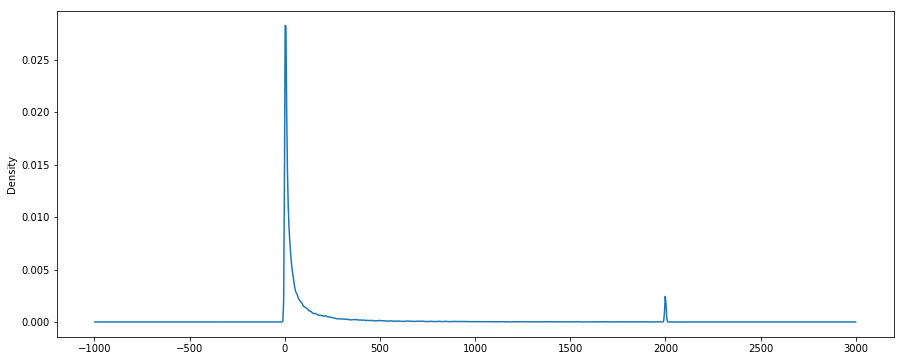

In [27]:
df['visit_count'].plot.kde(figsize=(15,6), bw_method=0.01)

<img src="https://i.kym-cdn.com/entries/icons/original/000/005/540/130221984383.png">

In [28]:
pd.pivot_table(df[df['visit_count'] > 1970], index = ['visit_count'], 
               columns=['gender', 'age'], aggfunc='count', values = 'uid')

gender          -     F                             M                      \
age             - 18-24 25-34 35-44 45-54  >=55 18-24  25-34  35-44 45-54   
visit_count                                                                 
1973          NaN   NaN   NaN   NaN   NaN   NaN   NaN    1.0    NaN   NaN   
1975          NaN   NaN   1.0   NaN   NaN   NaN   NaN    NaN    NaN   NaN   
1979          NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    1.0   NaN   
1983          NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   1.0   
1986          NaN   NaN   NaN   NaN   1.0   NaN   NaN    NaN    NaN   NaN   
1992          NaN   NaN   1.0   NaN   NaN   NaN   NaN    NaN    NaN   NaN   
1993          1.0   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   
2000         94.0  23.0  79.0  78.0  37.0  10.0  53.0  260.0  174.0  85.0   

gender             
age          >=55  
visit_count        
1973          NaN  
1975          NaN  
1979          NaN  
1983          NaN  
1986          NaN  
1992          NaN  
1993          NaN  
2000         34.0

Явный выброс (или вброс?), пока попробуем хотя бы слогарифмировать показатель и добавить параметр visit_count==2000

In [29]:
df['visit_count_log'] = df.visit_count.map(lambda x: np.log1p(x))
df['visit_count_2000'] = df.visit_count.map(lambda x: int(x==2000))

Посчитаем доли посещений в выходные дни, в рабочие часы и ночью. Рабочие часы будут с 8 до 20, а ночные - с 00 до 4. Еще хорошо бы посмотреть на частоту посещений. Заодно создадим флажок десяти классов конкатенацией строк - пока будем пытаться классифицировать все вместе

In [30]:
def get_weekend_share(weekday):
    '''returns share of weekend visits in list based on timestamp'''
    return len([day for day in weekday if int(day)>4])/len(weekday)

def get_workhours_share(timestamps):
    '''returns share of weekends in list based on timestamp'''
    return len([timestamp for timestamp in timestamps if 
                all([
                    int(datetime.datetime.utcfromtimestamp(timestamp/1000).hour)<21, 
                    int(datetime.datetime.utcfromtimestamp(timestamp/1000).hour)>7,
                    int(datetime.datetime.utcfromtimestamp(timestamp/1000).weekday())<5])
               ])/len(timestamps)

def get_night_share(hours):
    '''returns share of night visits in list based on timestamp'''
    return len([hour for hour in hours if int(hour)<5 or int(hour)>23])/len(hours)

def important_domains(domain_list):
    '''returns intersection with important domain list'''
    return [value for value in domain_list if value in memory_domain_list] 

In [31]:
%%time
df['mean_hour'] = df.hour_list.map(np.mean)
df['median_hour'] = df.hour_list.map(np.median)
df['mode_hour'] = df.hour_list.map(get_mode_or_median_at_least)
df['mean_day'] = df.weekday_list.map(np.mean)
df['median_day'] = df.weekday_list.map(np.median)
df['mode_day'] = df.weekday_list.map(get_mode_or_median_at_least)
df['visit_range'] = np.log1p(df['time_list'].map(np.ptp))
df['visit_freq'] = np.log1p(df['visit_range']/df['visit_count'])
df['weekend_share'] = df.weekday_list.map(get_weekend_share)
df['workhours_share'] = df.time_list.map(get_workhours_share)
df['night_share'] = df.hour_list.map(get_night_share)
df['class'] = df['gender_cat'].astype('str') + df['age_cat'].astype('str')
df['imp_domains'] = df.domain_list.map(important_domains)

CPU times: user 43.4 s, sys: 148 ms, total: 43.6 s
Wall time: 45.3 s


In [32]:
df.head(1)

gender    age                                   uid  \
0      F  18-24  d50192e5-c44e-4ae8-ae7a-7cfe67c8b777   

                                           user_json  \
0  {'visits': [{'url': 'http://zebra-zoya.ru/2000...   

                                         domain_list  gender_cat  age_cat  \
0  [b'zebra-zoya.ru', b'news.yandex.ru', b'sotovi...           0        0   

                                           time_list  \
0  [1419688144068, 1426666298001, 1426666298000, ...   

                                            url_list         hour_list  \
0  [http://zebra-zoya.ru/200028-chehol-organayzer...  [13, 8, 8, 6, 6]   

      ...      mean_day  median_day  mode_day  visit_range  visit_freq  \
0     ...           2.6         2.0         2     22.66605    1.710768   

   weekend_share  workhours_share  night_share  class  imp_domains  
0            0.2              0.4          0.0     00           []  

[1 rows x 27 columns]

Создадим датафрейм без тестовых значений, для поиграться с pairplot, и выберем кажущиеся наиболее важными фичи.

In [15]:
df_raw_test = df[df.age != '-']

In [34]:
pair_features_best_feeling_gender = ['mode_hour', 'visit_range', 'weekend_share', 
                              'workhours_share', 'night_share', 'gender']
pair_features_best_feeling_age = ['mode_hour', 'visit_range', 'weekend_share', 
                              'workhours_share', 'night_share', 'age']

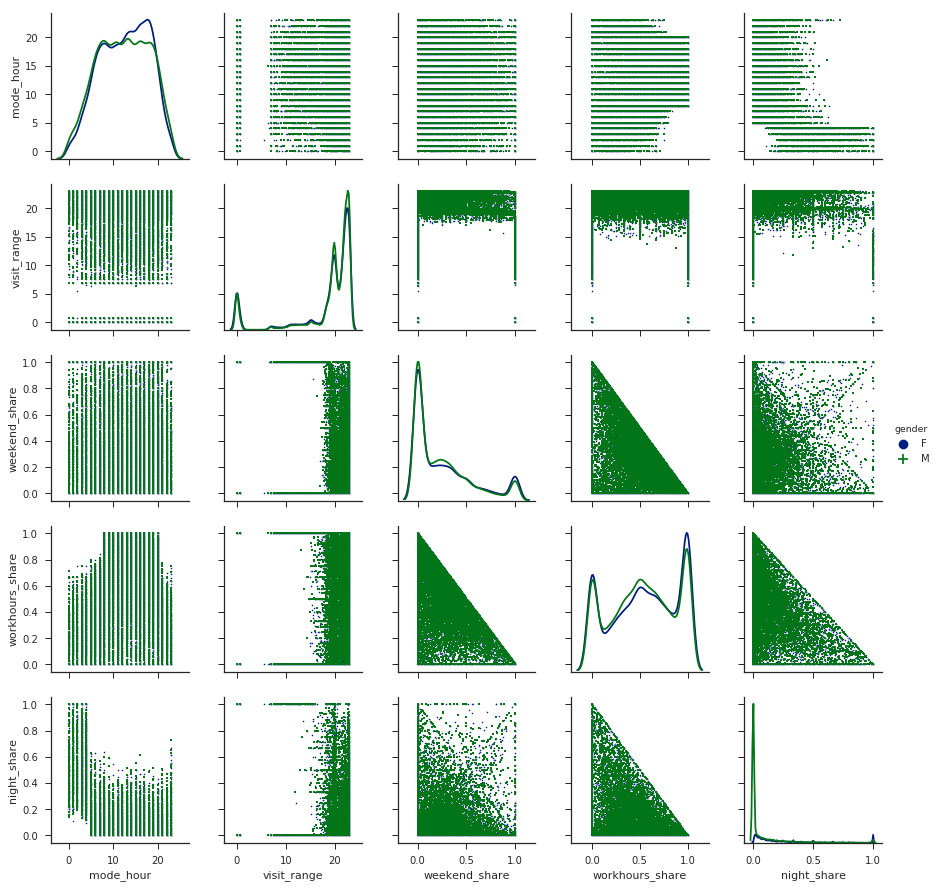

In [35]:
data_pair=df_raw_test[pair_features_best_feeling_gender]
sns.set(style="ticks", color_codes=True)
g=sns.pairplot(data_pair, diag_kind='kde', hue='gender', 
               plot_kws={"s": 3}, markers=["o", "+"], palette="dark")

for lh in g._legend.legendHandles: 
    lh._sizes = [100] 

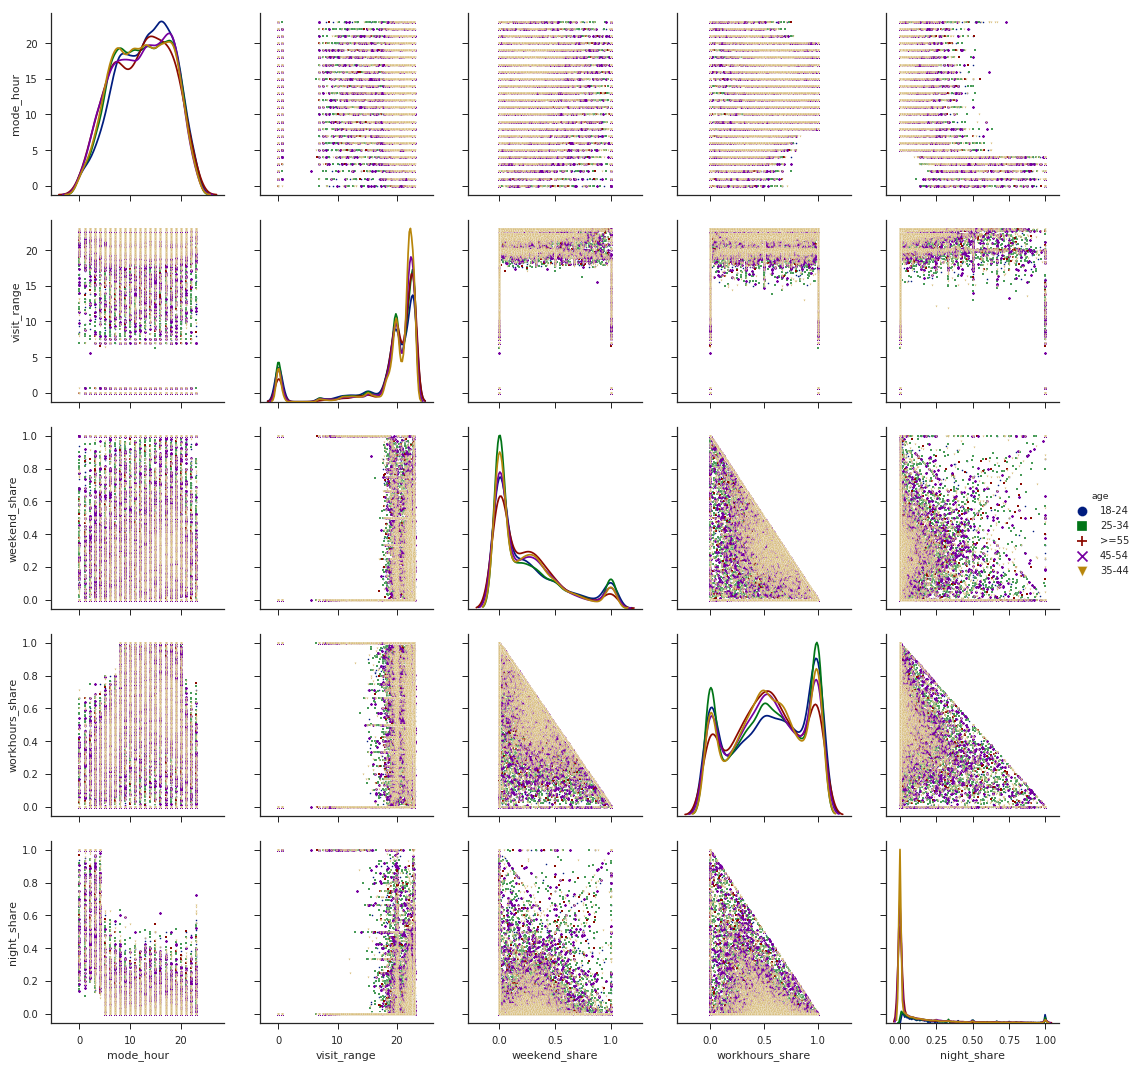

In [36]:
data_pair=df_raw_test[pair_features_best_feeling_age]
sns.set(style="ticks", color_codes=True)
g=sns.pairplot(data_pair, diag_kind='kde', hue='age', plot_kws={"s": 3}, 
               markers=["o", "s", "+", "x", "v"], palette="dark", size=3)

for lh in g._legend.legendHandles: 
    lh._sizes = [100] 

Кошмарно получилось, впрочем, и такого хватит, чтобы посмотреть на kde плоты. Вызывают интерес распределения night_share, workhours_share, weekend_share внутри наших классов. С долей ночных посещений вообще что-то несуразное в классе 35-44. А еще там же виден далееееекий огонек, подозрительно похожий на наших вброшенных двухтысячников

In [37]:
df_raw_test.groupby(by=['gender', 'age'])['night_share', 'workhours_share', 'weekend_share'].mean()

night_share  workhours_share  weekend_share
gender age                                               
F      18-24     0.060888         0.559235       0.269652
       25-34     0.070392         0.547832       0.265916
       35-44     0.067605         0.549484       0.260610
       45-54     0.076891         0.547935       0.262499
       >=55      0.079320         0.546018       0.261855
M      18-24     0.068379         0.542243       0.269378
       25-34     0.078256         0.537121       0.245670
       35-44     0.089803         0.533052       0.241903
       45-54     0.106507         0.524809       0.247508
       >=55      0.104702         0.517858       0.247232

In [38]:
df_raw_test[df_raw_test.night_share > 0.9].groupby(by=['gender', 'age']).count()\
.apply(lambda x:100*x/sum(x)).gender_cat

gender  age  
F       18-24     8.775137
        25-34    20.658135
        35-44     7.312614
        45-54     7.861060
        >=55      2.925046
M       18-24     6.032907
        25-34    21.389397
        35-44    15.904936
        45-54     7.312614
        >=55      1.828154
Name: gender_cat, dtype: float64

Мужчины в возрасте все-таки лазают по интернету по ночам чаще? Интригующе...
А у женщин чуть-чуть, но больше доля посещений в рабочее время.
Пора, наверное, погонять модельки. Создадим списки фичей и 3 варианта таргетов - на 10 классов, по полу, и по возрасту

In [39]:
features = [c for c in df_raw_test.columns.values if c not in ['class', 'gender', 'age', 'uid', 
                                                              'user_json', 'url_list', 'gender_cat', 
                                                              'age_cat', 'time_list', 'hour_list', 
                                                              'weekday_list', 'alphabets', 'imp_domains']]
numeric_features = [c for c in df_raw_test.columns.values if c not in ['class', 'domain_list', 
                                                                       'gender', 'age', 'uid', 
                                                                       'user_json', 'domain_list', 
                                                                       'gender_cat', 
                                                                       'age_cat', 'time_list', 
                                                                       'hour_list', 'weekday_list',
                                                                       'url_list', 'alphabets', 'imp_domains']]

target = 'class'
target_1 = 'gender'
target_2 = 'age'

А вдруг числовых признаков уже хватит, и совсем-совсем не нужно обрабатывать url? Можно написать функцию, прогоняющую дженерик классификаторы через фит-предикт, и выдающую датафрейм с accuracy и feature_importances_.
Хотя в процессе написания возникнет ощущение создания велосипеда =(

In [40]:
def do_we_even_need_text(classifiers, X_train, X_test, y_train, y_test):
    '''Runs fit-predict for generic classifiers in list. Returns DataFrame with results'''
    columns=['accuracy']
    columns.extend(list(X_train.columns))
    result=pd.DataFrame(columns=columns)
    for clf in classifiers:
        cur_clf = clf
        cur_clf.fit(X_train, y_train)
        predicts = cur_clf.predict(X_test)
        result = result.append(pd.DataFrame(
            np.concatenate((np.mean(predicts == y_test), 
                            cur_clf.feature_importances_), 
                           axis=None).reshape(1, -1), 
            columns=columns, index = [type(cur_clf)]))

    return result

Рассплитуем выборку 75/25 и посмотрим, какие числовые фичи будут наиболее полезны классификаторам с методом feature_importances_

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_raw_test[numeric_features], 
                                                    df_raw_test[target], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [42]:
classifiers=[XGBClassifier(), 
             AdaBoostClassifier(), 
             RandomForestClassifier()]
result = do_we_even_need_text(classifiers, X_train, X_test, y_train, y_test)
result

accuracy  visit_count  \
<class 'xgboost.sklearn.XGBClassifier'>             0.237853     0.093353   
<class 'sklearn.ensemble._weight_boosting.AdaBo...  0.240177     0.060000   
<class 'sklearn.ensemble._forest.RandomForestCl...  0.210847     0.070213   

                                                    visit_count_log  \
<class 'xgboost.sklearn.XGBClassifier'>                    0.000000   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.020000   
<class 'sklearn.ensemble._forest.RandomForestCl...         0.070408   

                                                    visit_count_2000  \
<class 'xgboost.sklearn.XGBClassifier'>                     0.000000   
<class 'sklearn.ensemble._weight_boosting.AdaBo...          0.000000   
<class 'sklearn.ensemble._forest.RandomForestCl...          0.000684   

                                                    mean_hour  median_hour  \
<class 'xgboost.sklearn.XGBClassifier'>              0.150812     0.039439   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.120000     0.060000   
<class 'sklearn.ensemble._forest.RandomForestCl...   0.110304     0.069141   

                                                    mode_hour  mean_day  \
<class 'xgboost.sklearn.XGBClassifier'>              0.053471  0.103840   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.060000  0.080000   
<class 'sklearn.ensemble._forest.RandomForestCl...   0.072002  0.097468   

                                                    median_day  mode_day  \
<class 'xgboost.sklearn.XGBClassifier'>               0.009897  0.017725   
<class 'sklearn.ensemble._weight_boosting.AdaBo...    0.000000  0.000000   
<class 'sklearn.ensemble._forest.RandomForestCl...    0.039699  0.041620   

                                                    visit_range  visit_freq  \
<class 'xgboost.sklearn.XGBClassifier'>                0.203840    0.117725   
<class 'sklearn.ensemble._weight_boosting.AdaBo...     0.180000    0.220000   
<class 'sklearn.ensemble._forest.RandomForestCl...     0.127488    0.115536   

                                                    weekend_share  \
<class 'xgboost.sklearn.XGBClassifier'>                  0.070753   
<class 'sklearn.ensemble._weight_boosting.AdaBo...       0.080000   
<class 'sklearn.ensemble._forest.RandomForestCl...       0.064557   

                                                    workhours_share  \
<class 'xgboost.sklearn.XGBClassifier'>                    0.065879   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.040000   
<class 'sklearn.ensemble._forest.RandomForestCl...         0.079024   

                                                    night_share  
<class 'xgboost.sklearn.XGBClassifier'>                0.073264  
<class 'sklearn.ensemble._weight_boosting.AdaBo...     0.080000  
<class 'sklearn.ensemble._forest.RandomForestCl...     0.041856

Уау, АдаБуст на наших героическим образом придуманных фичах выдал результат на 0,000000... лучше, чем наивный классификатор "Все вокруг - мужчины 25-34". Обрабатывать тексты и дополнительно нормализовывать числовые признаки все же придется =(
Классификаторы практически не смотрели на производные от visit_count. Ну и, средние значения важнее мод и медиан? Правда?
В общем, с наскока не получилось. Посмотрим хотя бы на корреляцию фич. Лучше поздно, чем никогда.

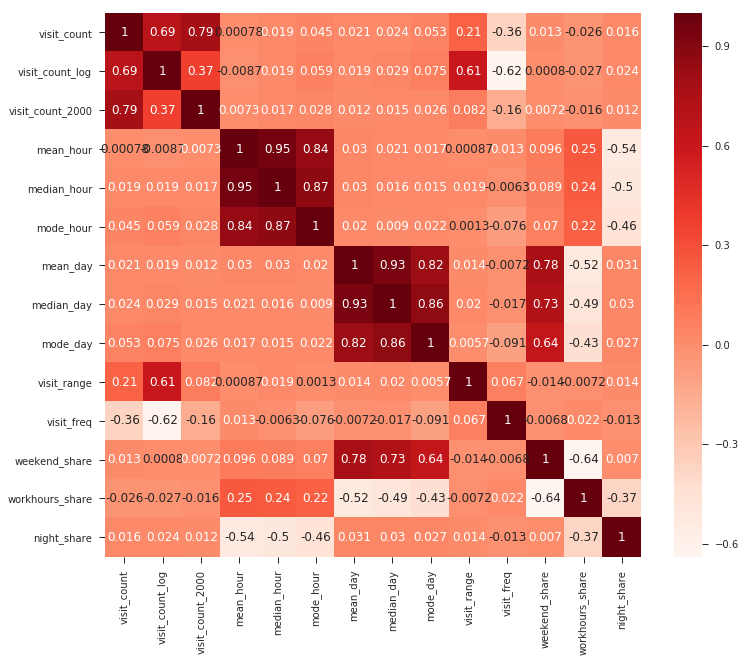

In [93]:
plt.figure(figsize=(12,10))
correlation = df_raw_test[numeric_features].corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
plt.show()

Конечно же, разумеется, без сомнения наши напиханные в кучу производные фичи коррелируют друг с другом. Значит, будем их резать. mode_day меньше коррелирует с weekend_share, поэтому оставляем моду, а не медиану или среднее. Из числа посещений оставим логарифм. Впрочем, держим в памяти флажок на 2000 - очень уж подозрительный там вброс. Мода часов посещений тоже предпочтительнее - да и по логике понятней, чем среднее. С частотой и общим логинтервалом посещений скорее ясно, почему оно коррелирует с логарифмом посещений: больше похождений - длиннее история по времени.  Но не очень понятно, что с этим делать. Ладно, оставим не frequency, а range.

In [44]:
best_features = ['mode_hour', 'visit_count_log', 'mode_day', 
                 'visit_range', 'weekend_share', 'workhours_share', 
                 'night_share']

X_train, X_test, y_train, y_test = train_test_split(df_raw_test[best_features], 
                                                    df_raw_test[target], 
                                                    test_size=0.25, 
                                                    random_state=42)
classifiers=[XGBClassifier(), 
             AdaBoostClassifier(), 
             RandomForestClassifier()]
result2 = do_we_even_need_text(classifiers, X_train, X_test, y_train, y_test)
result2

accuracy  mode_hour  \
<class 'xgboost.sklearn.XGBClassifier'>             0.241505   0.116347   
<class 'sklearn.ensemble._weight_boosting.AdaBo...  0.243165   0.100000   
<class 'sklearn.ensemble._forest.RandomForestCl...  0.204095   0.147772   

                                                    visit_count_log  mode_day  \
<class 'xgboost.sklearn.XGBClassifier'>                    0.179319  0.040576   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.220000  0.020000   
<class 'sklearn.ensemble._forest.RandomForestCl...         0.176959  0.081248   

                                                    visit_range  \
<class 'xgboost.sklearn.XGBClassifier'>                0.295375   
<class 'sklearn.ensemble._weight_boosting.AdaBo...     0.320000   
<class 'sklearn.ensemble._forest.RandomForestCl...     0.268405   

                                                    weekend_share  \
<class 'xgboost.sklearn.XGBClassifier'>                  0.130017   
<class 'sklearn.ensemble._weight_boosting.AdaBo...       0.180000   
<class 'sklearn.ensemble._forest.RandomForestCl...       0.115299   

                                                    workhours_share  \
<class 'xgboost.sklearn.XGBClassifier'>                    0.111838   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.060000   
<class 'sklearn.ensemble._forest.RandomForestCl...         0.141563   

                                                    night_share  
<class 'xgboost.sklearn.XGBClassifier'>                0.126527  
<class 'sklearn.ensemble._weight_boosting.AdaBo...     0.100000  
<class 'sklearn.ensemble._forest.RandomForestCl...     0.068754

Тааак, уже чуть получше, и мы еще с гиперпараметрами не игрались. Или может быть, пора использовать предположительно важные домены? Развернем их бинаризатором и пробежимся по признакам АдаБустом, пока он себя зарекомендовал лучше прочих.

In [45]:
mlb = MultiLabelBinarizer()
s=df_raw_test.imp_domains
df_raw_test1 = pd.concat([df_raw_test, 
                        pd.DataFrame(mlb.fit_transform(df_raw_test.imp_domains), 
                                     columns=mlb.classes_, index=df_raw_test.index)],
                        axis=1)

In [46]:
numeric_features_bin_domains = \
[c for c in df_raw_test1.columns.values if c not in ['class', 'domain_list','gender', 'age', 'uid', 
                                                                       'user_json', 'domain_list', 
                                                                       'gender_cat', 
                                                                       'age_cat', 'time_list', 
                                                                       'hour_list', 'weekday_list',
                                                                       'url_list', 'alphabets', 'imp_domains']]

target = 'class'
target_1 = 'gender'
target_2 = 'age'
X_train, X_test, y_train, y_test = train_test_split(df_raw_test1[numeric_features_bin_domains], 
                                                    df_raw_test1[target], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [47]:
classifiers=[AdaBoostClassifier(n_estimators=55, learning_rate=0.75),
             AdaBoostClassifier(n_estimators=65, learning_rate=0.6),
             AdaBoostClassifier(n_estimators=60, learning_rate=0.5),
             AdaBoostClassifier(n_estimators=70, learning_rate=0.7),
             AdaBoostClassifier(n_estimators=80, learning_rate=0.5)]
result3 = do_we_even_need_text(classifiers, X_train, X_test, y_train, y_test)
result3

accuracy  visit_count  \
<class 'sklearn.ensemble._weight_boosting.AdaBo...  0.250028     0.018182   
<class 'sklearn.ensemble._weight_boosting.AdaBo...  0.248589     0.015385   
<class 'sklearn.ensemble._weight_boosting.AdaBo...  0.250360     0.016667   
<class 'sklearn.ensemble._weight_boosting.AdaBo...  0.252241     0.014286   
<class 'sklearn.ensemble._weight_boosting.AdaBo...  0.251245     0.037500   

                                                    visit_count_log  \
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.018182   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.046154   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.050000   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.028571   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.012500   

                                                    visit_count_2000  \
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   

                                                    mean_hour  median_hour  \
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.109091     0.018182   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.107692     0.030769   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.100000     0.016667   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.085714     0.014286   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.112500     0.025000   

                                                    mode_hour  mean_day  \
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.000000  0.036364   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.015385  0.030769   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.000000  0.033333   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.028571  0.028571   
<class 'sklearn.ensemble._weight_boosting.AdaBo...   0.012500  0.037500   

                                                    median_day  mode_day  \
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.0       0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.0       0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.0       0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.0       0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...         0.0       0.0   

                                                          ...          \
<class 'sklearn.ensemble._weight_boosting.AdaBo...        ...           
<class 'sklearn.ensemble._weight_boosting.AdaBo...        ...           
<class 'sklearn.ensemble._weight_boosting.AdaBo...        ...           
<class 'sklearn.ensemble._weight_boosting.AdaBo...        ...           
<class 'sklearn.ensemble._weight_boosting.AdaBo...        ...           

                                                    b'unionpeer.org'  \
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...               0.0   

                                                    b'velosite.ru'  \
<class 'sklearn.ensemble._weight_boosting.AdaBo...             0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...             0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...             0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...             0.0   
<class 'sklearn.ensemble._weight_boosting.AdaBo...             0.0   

                                                    b'vesti

Чем-то эти домены все-таки помогли. Глянем на важность фич для лучшей модели

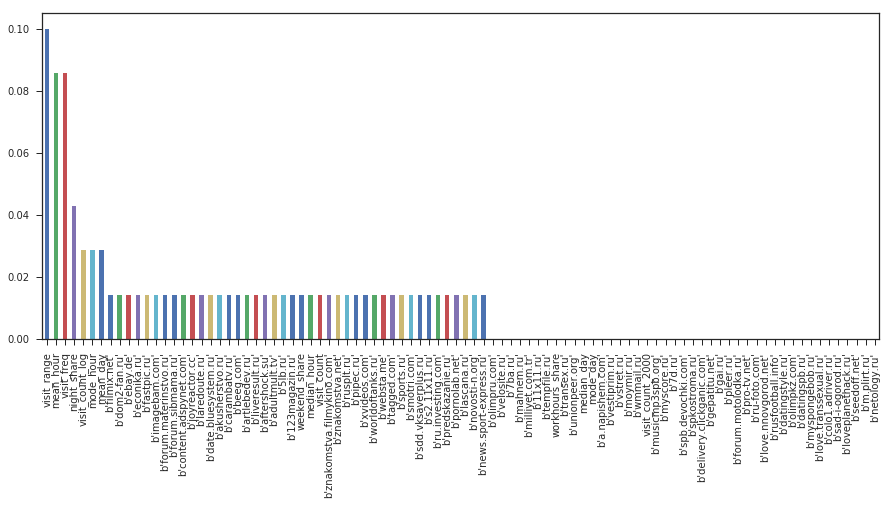

In [49]:
pd.Series(result3.iloc[3]).sort_values(ascending=False).tail(92).plot(kind='bar', figsize=(15,6))

In [50]:
ada_res = pd.Series(result3.iloc[3]).sort_values(ascending=False).tail(92)
best_for_ada = list(ada_res[ada_res>0].index)
best_for_ada

['visit_range',
 'mean_hour',
 'visit_freq',
 'night_share',
 'visit_count_log',
 'mode_hour',
 'mean_day',
 "b'filmix.net'",
 "b'dom2-fan.ru'",
 "b'ebay.de'",
 "b'econika.ru'",
 "b'fastpic.ru'",
 "b'imagebam.com'",
 "b'forum.materinstvo.ru'",
 "b'forum.sibmama.ru'",
 "b'content.adspynet.com'",
 "b'joyreactor.cc'",
 "b'laredoute.ru'",
 "b'date.bluesystem.ru'",
 "b'akusherstvo.ru'",
 "b'carambatv.ru'",
 "b'beeg.com'",
 "b'artlebedev.ru'",
 "b'liveresult.ru'",
 "b'aftershock.su'",
 "b'adultmult.tv'",
 "b'5lb.ru'",
 "b'123magazin.ru'",
 'weekend_share',
 'median_hour',
 'visit_count',
 "b'znakomstva.filmykino.com'",
 "b'znakomstva.net'",
 "b'rusplt.ru'",
 "b'pipec.ru'",
 "b'xvideos.com'",
 "b'worldoftanks.ru'",
 "b'websta.me'",
 "b'tagged.com'",
 "b'sports.ru'",
 "b'smotri.com'",
 "b'sdd.vksaverplus.ru'",
 "b's2.11x11.ru'",
 "b'ru.investing.com'",
 "b'predskazanie.ru'",
 "b'pornolab.net'",
 "b'lascana.ru'",
 "b'novosti-n.org'",
 "b'news.sport-express.ru'"]

Посмотрим, насколько плохо дела идут в разных классах

In [ ]:
clf = AdaBoostClassifier(n_estimators=70, learning_rate=0.7)
clf.fit(X_train[best_for_ada], y_train)
predicts = clf.predict(X_test[best_for_ada])
tags=df_raw_test['class'].unique()
print('accuracy %s' % accuracy_score(predicts, y_test))
print(classification_report(y_test, predicts, target_names=tags, zero_division=0))

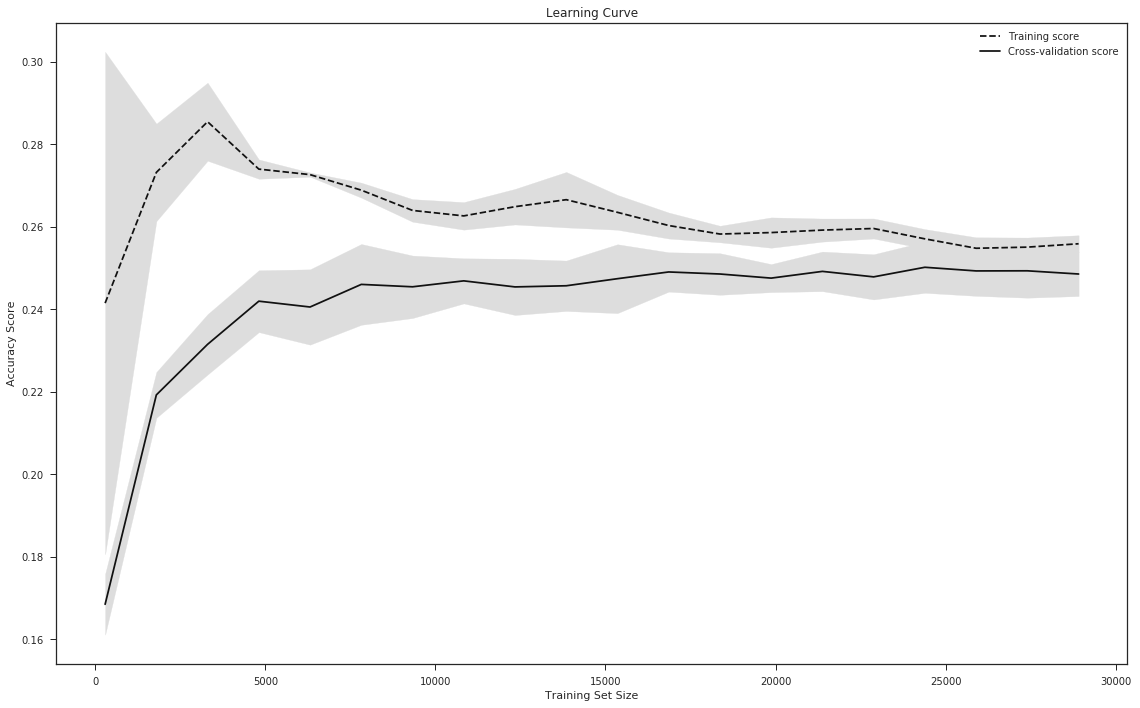

In [52]:
train_sizes, train_scores, test_scores = learning_curve(AdaBoostClassifier(n_estimators=70, learning_rate=0.7), 
                                                        df_raw_test1[numeric_features_bin_domains], 
                                                        df_raw_test1[target],
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 20))

def plot_learning_curve(train_sizes, train_scores, test_scores):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(16,10))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
plot_learning_curve(train_sizes, train_scores, test_scores)

Не ахти. Вообще не попали в 5 классов, можно было бы вообще не браться их предсказывать, и получить больший результат на коммите проекта.
Пора признавать, что без текст майнинга не обойтись. Начнем с TF-IDF. У нас уже есть перечень доменов domain_list для каждого посетителя, нарисуем фейковый токенайзер, чтобы дефолтный не порубил наши домены на что-нибудь. Соорудим базовый пайплайн с tf-idf и наивным Байесом. n-граммы нам, наверное, тут не нужны.

In [16]:
def fake_tokenizer(domain):
    return domain

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df_raw_test.domain_list, 
                                                    df_raw_test[target], 
                                                    test_size=0.25, 
                                                    random_state=42)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=fake_tokenizer, lowercase=False, max_features = 1000)),
    ('clf', MultinomialNB())])
pipeline.fit(X_train, y_train)

predicts = pipeline.predict(X_test)
#np.mean(preds == y_test)

tags=df_raw_test['class'].unique()
print('accuracy %s' % accuracy_score(predicts, y_test))
print(classification_report(y_test, predicts, target_names=tags, zero_division=0))

accuracy 0.2865522966242391
              precision    recall  f1-score   support

          00       0.31      0.04      0.06       700
          11       0.28      0.44      0.34      1746
          01       0.26      0.08      0.12      1081
          14       0.25      0.06      0.10       616
          03       0.00      0.00      0.00       256
          02       0.45      0.01      0.02       488
          12       0.30      0.67      0.41      2140
          04       0.28      0.18      0.22      1277
          10       0.03      0.00      0.00       525
          13       0.00      0.00      0.00       206

    accuracy                           0.29      9035
   macro avg       0.22      0.15      0.13      9035
weighted avg       0.26      0.29      0.22      9035



О, навскидку на 75% процентах выборки получили 0.286. Немного разочаровывает и ставит под сомнение важность числовых признаков, просто так накинули Байеса на tfidf, и сразу получили минимальный результат, нужный для сдачи проекта. Впрочем, на этом мы, конечно же, не остановимся. В классы женщин и мужчин 45-54 не попали пока вообще, тема для дальнейшего изучения.

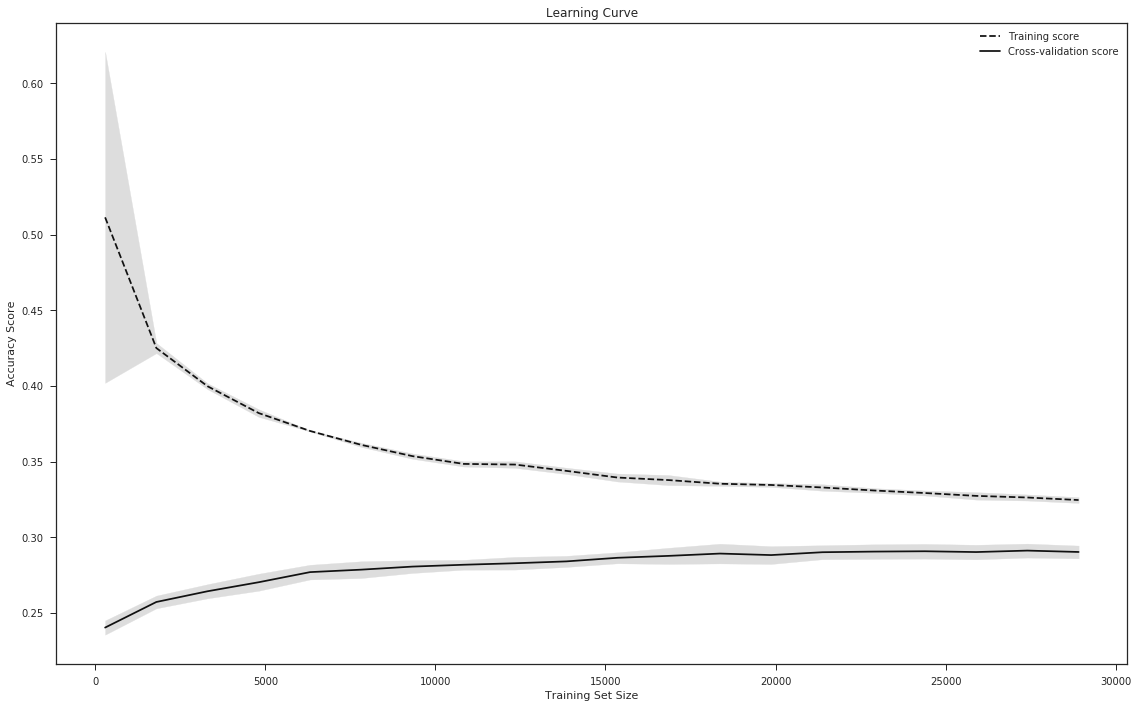

In [55]:
train_sizes, train_scores, test_scores = learning_curve(Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=fake_tokenizer, lowercase=False, max_features = 1000)),
    ('clf', MultinomialNB())]), 
                                                        df_raw_test.domain_list, 
                                                        df_raw_test[target],
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 20))

plot_learning_curve(train_sizes, train_scores, test_scores)

In [56]:
#model_file = "02project01_model.pickle"

#with open(os.environ['HOME'] + '/' + model_file, 'wb') as f:
#    pickle.dump(pipeline, f)
    
#os.chmod(os.environ['HOME'] + '/' + model_file, 0o644)

Попробуем поработать с текстом ссылок, оставив в каждой ссылке только слова, отфильтровав по символам.

In [17]:
def another_tokenizer(url):
    return filter(str.isalpha, str(url))

corpus = df_raw_test.url_list
vectorizer = TfidfVectorizer(tokenizer=another_tokenizer, lowercase=False, max_features=2000)
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'µ', 'º', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'ï', 'ð', 'ñ', 'ó', 'ö', 'ø', 'ù', 'ú', 'ü', 'ý', 'ÿ', 'ă', 'ą', 'č', 'ę', 'ğ', 'ı', 'ķ', 'ł', 'ō', 'œ', 'ř', 'ś', 'ş', 'ū', 'ż', 'ư', 'ș', 'ȯ', 'ə', 'ʹ', 'ά', 'έ', 'ή', 'ί', 'α', 'γ', 'δ', 'ε', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω', 'ό', 'ώ', 'Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'ђ', 'ѓ', 'є', 'ѕ', 'і', 'ї', 'ј', 'ў', 'ґ',

Упс. Вообще говоря, я хотел оставить только слова, но что-то пошло не так, и остались одни буквы. Причем греческие, арабские(?), китайские, и, похоже, японская катакана? В общем, криворукость и отвага вознаграждаемы, и можно попробовать новые признаки, нужно только найти, к какому алфавиту буквы принадлежат.

In [18]:
list_of_alphabets = set()
for symbol in vectorizer.get_feature_names(): 
    list_of_alphabets.add(unicodedata.name(symbol).split()[0])
list_of_alphabets

{'ARABIC',
 'ARMENIAN',
 'CJK',
 'CYRILLIC',
 'DEVANAGARI',
 'GEORGIAN',
 'GREEK',
 'HALFWIDTH',
 'HANGUL',
 'HEBREW',
 'LATIN',
 'MASCULINE',
 'MICRO',
 'MODIFIER',
 'SYLOTI'}

In [60]:
def get_alphabets(url_list):
    list_of_alphabets = set() 
    for symbol in filter(str.isalpha, list(''.join(url_list))):
        try:
            list_of_alphabets.add(unicodedata.name(symbol).split()[0])
        except ValueError:
            list_of_alphabets.add('ERROR')
    return list(list_of_alphabets)

In [61]:
df_raw_test1['alphabets'] = df_raw_test['url_list'].map(get_alphabets)

In [62]:
mlb1 = MultiLabelBinarizer()
df_raw_test2 = pd.concat([df_raw_test1, 
                        pd.DataFrame(mlb1.fit_transform(df_raw_test1.alphabets), 
                                     columns=mlb1.classes_, index=df_raw_test1.index)],
                        axis=1)

In [66]:
a_numeric_features = [c for c in df_raw_test2.columns.values if c not in ['class', 'domain_list', 
                                                                       'gender', 'age', 'uid', 
                                                                       'user_json', 'domain_list', 
                                                                       'gender_cat', 
                                                                       'age_cat', 'time_list', 
                                                                       'hour_list', 'weekday_list',
                                                                       'url_list', 'alphabets', 'imp_domains']]

target = 'class'
target_1 = 'gender'
target_2 = 'age'

In [64]:
a_numeric_features

['visit_count',
 'visit_count_log',
 'visit_count_2000',
 'mean_hour',
 'median_hour',
 'mode_hour',
 'mean_day',
 'median_day',
 'mode_day',
 'visit_range',
 'visit_freq',
 'weekend_share',
 'workhours_share',
 'night_share',
 "b'11x11.ru'",
 "b'123magazin.ru'",
 "b'5lb.ru'",
 "b'7ba.ru'",
 "b'7d.ru'",
 "b'a.napishem.com'",
 "b'adultmult.tv'",
 "b'aftershock.su'",
 "b'akusherstvo.ru'",
 "b'artlebedev.ru'",
 "b'beeg.com'",
 "b'carambatv.ru'",
 "b'colo1.adriver.ru'",
 "b'content.adspynet.com'",
 "b'date.bluesystem.ru'",
 "b'datingspb.ru'",
 "b'datingstyle.ru'",
 "b'delivery.clickganic.com'",
 "b'dom2-fan.ru'",
 "b'ebay.de'",
 "b'econika.ru'",
 "b'fastpic.ru'",
 "b'filmix.net'",
 "b'forum.materinstvo.ru'",
 "b'forum.motolodka.ru'",
 "b'forum.sibmama.ru'",
 "b'gai.ru'",
 "b'gepatitu.net'",
 "b'imagebam.com'",
 "b'joyreactor.cc'",
 "b'laredoute.ru'",
 "b'lascana.ru'",
 "b'liveresult.ru'",
 "b'love.nnovgorod.net'",
 "b'love.transsexual.ru'",
 "b'loveplanethack.ru'",
 "b'm.plirt.ru'",
 "b'ma

In [123]:
0.72*0.45

0.324

In [119]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [120]:
X_train, X_test, y_train, y_test = train_test_split(df_raw_test2[a_numeric_features], 
                                                    df_raw_test2[target], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [122]:
clf = LogisticRegression()
clf.fit(scaler.fit_transform(X_train[a_numeric_features]), y_train)
predicts = clf.predict(scaler.fit_transform(X_test[a_numeric_features]))
tags=df_raw_test[target].unique()
print('accuracy %s' % accuracy_score(predicts, y_test))
print(classification_report(y_test, predicts, target_names=tags, zero_division=0))

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



accuracy 0.24936358605423353
              precision    recall  f1-score   support

          00       0.29      0.01      0.01       700
          11       0.24      0.33      0.28      1746
          01       0.23      0.02      0.04      1081
          14       0.36      0.01      0.02       616
          03       0.00      0.00      0.00       256
          02       0.43      0.01      0.01       488
          12       0.25      0.73      0.37      2140
          04       0.28      0.06      0.11      1277
          10       0.12      0.00      0.00       525
          13       0.00      0.00      0.00       206

    accuracy                           0.25      9035
   macro avg       0.22      0.12      0.08      9035
weighted avg       0.25      0.25      0.17      9035



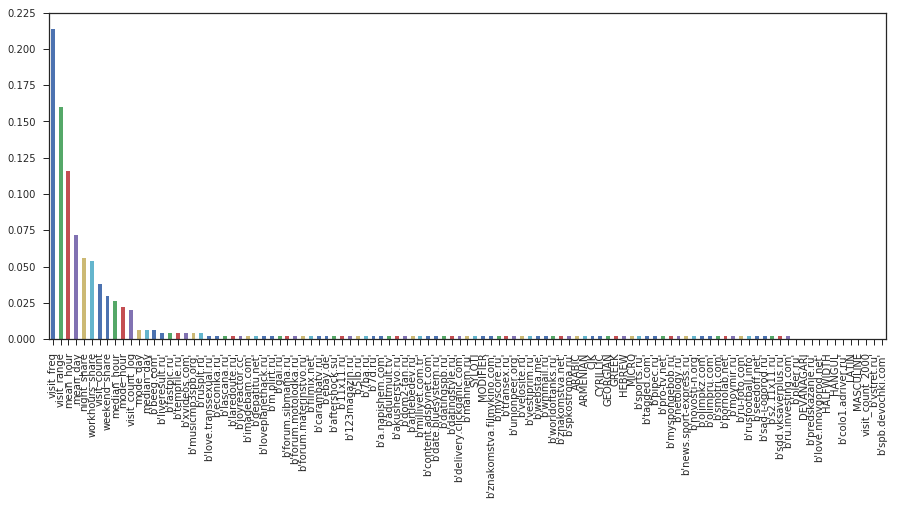

In [82]:
pd.Series(clf.feature_importances_, index=a_numeric_features)\
.sort_values(ascending=False).plot(kind='bar', figsize=(15,6))

Пока что лучший результат из не-tfidf. Из признаков алфавита адабуст откликался только на кириллические символы.


А что дальше? Конечно, можно было бы начать играться с параметрами, часами пить кофе, глядя на работающий ГридСерч, комбинировать разные модели для классов отдельно. 
Но, кажется, сначала стоит попробовать собрать текст по ссылкам, наверняка он будет важен - хотя бы заголовки.
Попробуем пореквестировать с каким-нибудь непитоновским хедером на тестовом массиве в 5 строк.

In [ ]:
def get_titles(url_list):
    '''takes url list, returns list of page titles'''
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1)\
               AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    titles_list=[]
    for url in url_list:
        try:
            r=requests.get(url, headers=headers)
            if r.status_code == 200:
                soup = bs4.BeautifulSoup(r.text,'lxml') 
                titles_list.append(soup.title.text)
        except: pass
    return titles_list

In [ ]:
test_requests_df = pd.DataFrame(df_raw_test.iloc[:5]['url_list'])

In [ ]:
%%time
test_requests_df['titles'] = test_requests_df.url_list.apply(get_titles)


<font size="2">Wall time: 3min 19s</font>
<font size="4">Wall time: 3min 19s</font>
<font size="7">Wall time: 3min 19s</font>
<img src="https://i.kym-cdn.com/entries/icons/original/000/000/472/seriouscatcover.jpg">

<font size="6">Ok, google, how to parse 5 million urls with python ASAP</font>